# Models Comparison for TinyML

In [35]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import m2cgen as m2c
from micromlgen import port

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [36]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.set_random_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [37]:
with open('../data/X-all.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../data/y-all.pkl', 'rb') as f:
    y = pickle.load(f)

In [38]:
X = np.concatenate((X[:250], X[750:1000], X[1500:]), axis=0)
y = np.concatenate((y[:250], y[750:1000], y[1500:]), axis=0)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [44]:
X_test[:100]

array([[ 0.03,  0.06,  1.06, -0.03,  0.1 ,  1.05, -0.14,  0.07,  0.98,
        -0.13,  0.04,  0.94, -0.1 ,  0.03,  0.9 , -0.04,  0.14,  0.95,
        -0.01,  0.11,  1.01, -0.02,  0.13,  1.03, -0.14,  0.11,  1.04,
        -0.18,  0.1 ,  1.  , -0.17, -0.19,  0.88,  0.09, -0.22,  0.9 ,
         0.13, -0.17,  0.93,  0.05,  0.04,  1.05,  0.01,  0.04,  1.06,
        -0.05,  0.07,  1.04, -0.14,  0.07,  0.97, -0.11,  0.03,  0.92,
        -0.08,  0.03,  0.89, -0.04,  0.14,  0.97],
       [ 0.1 , -0.2 ,  0.93,  0.15, -0.12,  1.05,  0.11, -0.06,  1.07,
         0.08, -0.05,  1.06, -0.13,  0.08,  0.99, -0.14,  0.06,  0.96,
        -0.14,  0.06,  0.94, -0.06,  0.  ,  0.91, -0.05,  0.04,  0.92,
         0.04,  0.04,  1.05,  0.04,  0.04,  1.07,  0.02,  0.06,  1.07,
        -0.03, -0.08,  1.02, -0.04, -0.11,  0.97, -0.03, -0.14,  0.94,
         0.07, -0.17,  0.9 ,  0.1 , -0.14,  0.92,  0.02,  0.09,  1.07,
         0.01,  0.08,  1.08, -0.04,  0.09,  1.07],
       [-0.01,  0.05,  1.07, -0.1 ,  0.17,  0.

## Model Spotting

In [18]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [19]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [45]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,76 0,03
LR - 0,56 0,02
CART - 0,77 0,03
SVC - 0,91 0,02
RF - 0,98 0,01


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (5).

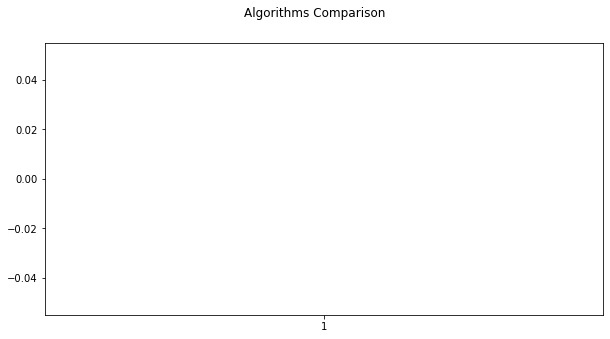

In [46]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

# Valutazione Inferance Rate medio (|X_test| = 100)

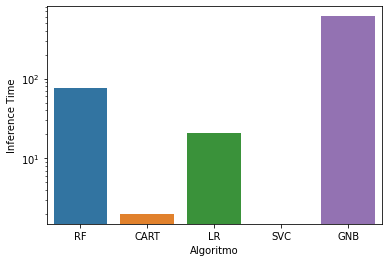

In [47]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

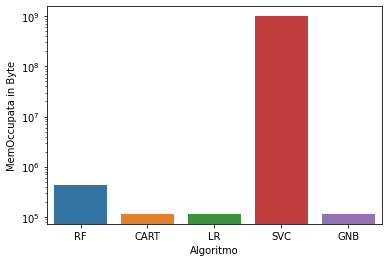

In [50]:
csv = read_csv("MemOccupationReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
g.set_yscale('log')
plt.ylabel("MemOccupata in Byte")
plt.show()
# SVC in overlow

# Export Models in C code

In [28]:
# Models in Pipeline
modelsInPipeline = []
modelsInPipeline.append('LR')

In [29]:
for name, model in models:
    prepath = 'exportedModels/'
    path = prepath + name + '.h'
    if name in modelsInPipeline:
        model = model[1]
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))